<a href="https://colab.research.google.com/github/heidarimohsen92/ANPR_IR/blob/main/tarin_ocr_fasterrcnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Check if NVIDIA GPU is enabled
!nvidia-smi

Sun Feb 12 19:17:51 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.47.03    Driver Version: 510.47.03    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   52C    P0    27W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Detecto Demo

Thanks for checking out [Detecto](https://github.com/alankbi/detecto)

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


## install the Detecto package using pip. 

In [ ]:
# Note: if it states you must restart the runtime in order to use a
# newly installed version of a package, you do NOT need to do this. 
!pip install detecto

Import everything we need in the following code block:

In [ ]:
import torch
import torchvision
import matplotlib.pyplot as plt
from torchvision import transforms
from detecto import core, utils, visualize

import random
import glob
import os
import pickle
import xml.etree.ElementTree as ET
from os import listdir, getcwd
from os.path import join

# Download ALPR_Dataset

In [ ]:
# download ALPR_Dataset
!git clone https://github.com/roozbehrajabi/ALPR_Dataset.git

Cloning into 'ALPR_Dataset'...
remote: Enumerating objects: 8947, done.
remote: Total 8947 (delta 0), reused 0 (delta 0), pack-reused 8947
Receiving objects: 100% (8947/8947), 234.00 MiB | 24.75 MiB/s, done.
Resolving deltas: 100% (1646/1646), done.
Updating files: 100% (8969/8969), done.


## preprocess data

In [ ]:

def split_data(dir_path, threshold=0.20):
    filenames = glob.glob(os.path.join(dir_path, "*.jpg"))
    random.shuffle(filenames)
    thr = int(threshold * len(filenames))
    
    train_data = filenames[thr:]
    test_data = filenames[:thr]
    train_annotate = [str(f).replace("Originals", "Annotations").replace(".jpg", ".xml") for f in train_data]
    test_annotate = [str(f).replace("Originals", "Annotations").replace(".jpg", ".xml") for f in test_data]
    return train_data, train_annotate, test_data, test_annotate

# move data
def move_files(list_path, save_path):
    for file_path in list_path:
        file_name = file_path.split("/")[-1]
        new_path = os.path.join(save_path, file_name)
        os.rename(file_path, new_path)
        
    print("Finished moving data")

In [ ]:
dir_path = '/content/ALPR_Dataset/Faster_R-CNN_dataset/Originals/'
tr_img_lst, tr_annot_lst, val_img_lst, val_annot_lst = split_data(dir_path, threshold=0.20)

!mkdir -p /content/train
train_path = '/content/train'
move_files(tr_img_lst, train_path)
move_files(tr_annot_lst, train_path) 


!mkdir -p /content/val
val_path = '/content/val'
move_files(val_img_lst, val_path)
move_files(val_annot_lst, val_path) 

Finished moving data
Finished moving data
Finished moving data
Finished moving data


In [ ]:
print ('train: images + labels =', end=" ") 
!ls /content/train/ | wc -l 

print ('val: images + labels =', end=" ") 
!ls /content/val/ | wc -l 


train: images + labels = 2630
val: images + labels = 656


### unique classes

In [ ]:
df = utils.xml_to_csv("/content/train", 'train.csv')
df

,filename,width,height,class,xmin,ymin,xmax,ymax,image_id
0,2183.jpg,640,128,2,14,13,75,110,0
1,2183.jpg,640,128,1,93,15,130,110,0
2,2183.jpg,640,128,vav,181,21,244,108,0
3,2183.jpg,640,128,3,284,18,347,114,0
4,2183.jpg,640,128,5,348,21,408,115,0
...,...,...,...,...,...,...,...,...,...
10499,1992.jpg,640,128,7,279,18,337,109,1314
10500,1992.jpg,640,128,4,345,19,403,107,1314
10501,1992.jpg,640,128,9,410,18,466,108,1314
10502,1992.jpg,640,128,1,498,37,537,114,1314


In [ ]:
class_names = df['class'].unique()
class_names

array(['2', '1', 'vav', '3', '5', '9', '8', 'be', '6', 'taa', '4', '7',
       'lam', 'ain', 'sin', 'ghaf', '0', 'mim', 'saat', 'dal', 'jim',
       'he', 'non', 'malol', 'ye', 'te', 'alef', 'pe'], dtype=object)

In [ ]:
list_classes = list(class_names)
list_classes.sort()
print(list_classes)
print(len(list_classes))

['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'ain', 'alef', 'be', 'dal', 'ghaf', 'he', 'jim', 'lam', 'malol', 'mim', 'non', 'pe', 'saat', 'sin', 'taa', 'te', 'vav', 'ye']
28


### create dataset 

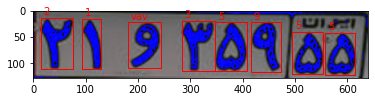

In [ ]:
# Create our train dataset
dataset = core.Dataset('/content/train/')

# Create our validation dataset
val_dataset = core.Dataset('/content/val/')


# dataset[i] returns a tuple containing our transformed image and
# and a dictionary containing label and box data
image, target = dataset[0]

# Show our image along with the box. Note: it may
# be colored oddly due to being normalized by the 
# dataset and then reverse-normalized for plotting
visualize.show_labeled_image(image, target['boxes'], target['labels'])

# train detecto model

In [ ]:
# Create the loader for our training dataset
loader = core.DataLoader(dataset, batch_size=16, shuffle=True)

# # Create our model, passing in all unique classes we're predicting
# # Note: make sure these match exactly with the labels in the XML/CSV files!
model = core.Model(list_classes)

# Train the model! 
losses = model.fit(loader, val_dataset, epochs=20, learning_rate=0.01, lr_step_size=5, verbose=True)


/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth


  0%|          | 0.00/160M [00:00<?, ?B/s]

Epoch 1 of 20
Begin iterating over training dataset


100%|██████████| 83/83 [02:36<00:00,  1.89s/it]


Begin iterating over validation dataset


100%|██████████| 328/328 [00:20<00:00, 15.72it/s]


Loss: 0.5040004289731747
Epoch 2 of 20
Begin iterating over training dataset


100%|██████████| 83/83 [02:37<00:00,  1.90s/it]


Begin iterating over validation dataset


100%|██████████| 328/328 [00:21<00:00, 15.46it/s]


Loss: 0.3346540529916926
Epoch 3 of 20
Begin iterating over training dataset


100%|██████████| 83/83 [02:37<00:00,  1.90s/it]


Begin iterating over validation dataset


100%|██████████| 328/328 [00:20<00:00, 15.65it/s]


Loss: 0.31346870540845684
Epoch 4 of 20
Begin iterating over training dataset


100%|██████████| 83/83 [02:37<00:00,  1.90s/it]


Begin iterating over validation dataset


100%|██████████| 328/328 [00:21<00:00, 15.51it/s]


Loss: 0.27045948321862917
Epoch 5 of 20
Begin iterating over training dataset


100%|██████████| 83/83 [02:37<00:00,  1.90s/it]


Begin iterating over validation dataset


100%|██████████| 328/328 [00:20<00:00, 15.64it/s]


Loss: 0.2646777693454812
Epoch 6 of 20
Begin iterating over training dataset


100%|██████████| 83/83 [02:37<00:00,  1.90s/it]


Begin iterating over validation dataset


100%|██████████| 328/328 [00:21<00:00, 15.49it/s]


Loss: 0.22893422433152433
Epoch 7 of 20
Begin iterating over training dataset


100%|██████████| 83/83 [02:37<00:00,  1.90s/it]


Begin iterating over validation dataset


100%|██████████| 328/328 [00:20<00:00, 15.74it/s]


Loss: 0.22622271188784662
Epoch 8 of 20
Begin iterating over training dataset


100%|██████████| 83/83 [02:37<00:00,  1.90s/it]


Begin iterating over validation dataset


100%|██████████| 328/328 [00:21<00:00, 15.56it/s]


Loss: 0.22670047425823966
Epoch 9 of 20
Begin iterating over training dataset


100%|██████████| 83/83 [02:37<00:00,  1.90s/it]


Begin iterating over validation dataset


100%|██████████| 328/328 [00:20<00:00, 15.64it/s]


Loss: 0.2270418368052782
Epoch 10 of 20
Begin iterating over training dataset


100%|██████████| 83/83 [02:37<00:00,  1.90s/it]


Begin iterating over validation dataset


100%|██████████| 328/328 [00:21<00:00, 15.58it/s]


Loss: 0.22619447048480917
Epoch 11 of 20
Begin iterating over training dataset


100%|██████████| 83/83 [02:37<00:00,  1.90s/it]


Begin iterating over validation dataset


100%|██████████| 328/328 [00:20<00:00, 15.65it/s]


Loss: 0.2227895229873134
Epoch 12 of 20
Begin iterating over training dataset


100%|██████████| 83/83 [02:37<00:00,  1.90s/it]


Begin iterating over validation dataset


100%|██████████| 328/328 [00:21<00:00, 15.61it/s]


Loss: 0.22348154938166462
Epoch 13 of 20
Begin iterating over training dataset


100%|██████████| 83/83 [02:37<00:00,  1.89s/it]


Begin iterating over validation dataset


100%|██████████| 328/328 [00:21<00:00, 15.61it/s]


Loss: 0.22357236060154875
Epoch 14 of 20
Begin iterating over training dataset


100%|██████████| 83/83 [02:37<00:00,  1.89s/it]


Begin iterating over validation dataset


100%|██████████| 328/328 [00:20<00:00, 15.70it/s]


Loss: 0.22259254912595924
Epoch 15 of 20
Begin iterating over training dataset


100%|██████████| 83/83 [02:37<00:00,  1.90s/it]


Begin iterating over validation dataset


100%|██████████| 328/328 [00:21<00:00, 15.51it/s]


Loss: 0.2232646431047015
Epoch 16 of 20
Begin iterating over training dataset


100%|██████████| 83/83 [02:37<00:00,  1.90s/it]


Begin iterating over validation dataset


100%|██████████| 328/328 [00:20<00:00, 15.79it/s]


Loss: 0.2226494515042116
Epoch 17 of 20
Begin iterating over training dataset


100%|██████████| 83/83 [02:37<00:00,  1.89s/it]


Begin iterating over validation dataset


100%|██████████| 328/328 [00:20<00:00, 15.81it/s]


Loss: 0.22362647353239903
Epoch 18 of 20
Begin iterating over training dataset


100%|██████████| 83/83 [02:36<00:00,  1.89s/it]


Begin iterating over validation dataset


100%|██████████| 328/328 [00:20<00:00, 15.69it/s]


Loss: 0.221703528108575
Epoch 19 of 20
Begin iterating over training dataset


100%|██████████| 83/83 [02:37<00:00,  1.89s/it]


Begin iterating over validation dataset


100%|██████████| 328/328 [00:21<00:00, 15.57it/s]


Loss: 0.22202310720231475
Epoch 20 of 20
Begin iterating over training dataset


100%|██████████| 83/83 [02:36<00:00,  1.89s/it]


Begin iterating over validation dataset


100%|██████████| 328/328 [00:21<00:00, 15.60it/s]

Loss: 0.2226466537657671


## Plot losses over

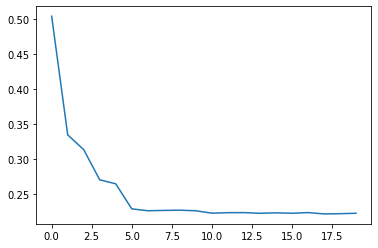

In [ ]:
# Plot the losses over time
plt.plot(losses)
plt.show()

## Results from validation set:

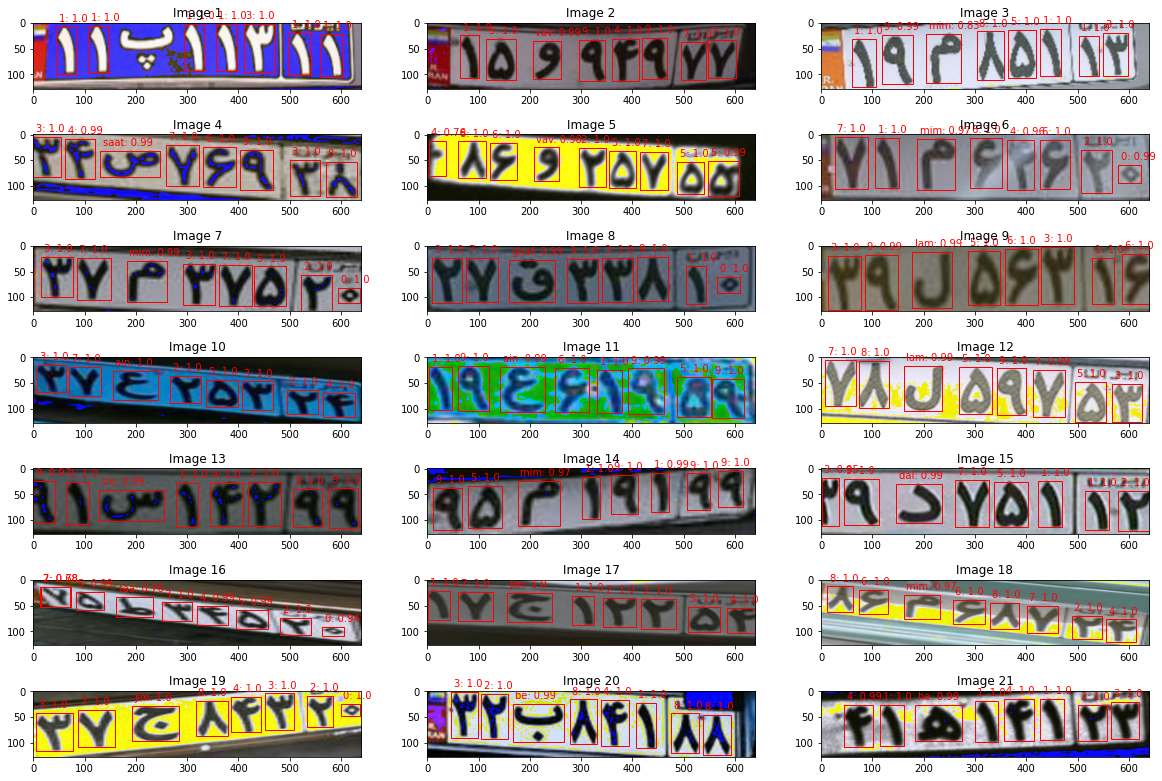

In [ ]:
images = []
# Create a list of images 0, 3, 6, ... 63 from val_dataset
for i in range(0, 63, 3):
    image, _ = val_dataset[i]
    images.append(image)

# Plot a 7x3 grid of the model's predictions on our 21 images
visualize.plot_prediction_grid(model, images, dim=(7, 3), figsize=(20, 14))

## save weights

In [ ]:
# save weights
model.save('ocr_weights.pth')
